In [ ]:
## EEG signal classification into wake and drowsy using CNN network

## adding upsampling through SMOTE & a different network

## POSSIBLE PROBLEMS & SOLUTIONS:
# 1. overfitting (see the plots - how bad ?) 
# no. of training examples: 83076 (train set) = Train on 74768 samples, validate on 8308 samples
# no. of trainable parameters: 4,793,957
# => reduce the no. of epochs
#    upsample data, 
#    reduce parameters/ change network, 
#    use dropout (in last-but-one layer)
##   WHERE IS THE LEARNING RATE BEING SPECIFIED ?

# 2. issue with parameter values: softmax vs sigmoid,  dense = 1 or 2,  binary or categorical cross-entropy

# 3. conversion of CNN output (float) to category (0,1) - why not done by the model?


## how to do train test split keeping class distribution similar
## use stratified_sampling (keep class ratios similar in train test sets) instead of random sampling
# https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
## class_weight = balanced (giving more weightage to penalties for the smaller class)
# https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work



##  INFERENCE: recall is low (0.65) for sleep state (class 1)  ##

#(array([0.92174321, 0.89073806]),
# array([0.98116972, 0.64823591]),
# array([0.95052854, 0.75038098]),
# array([8019, 1899]))


In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


/home/intern_eyecare/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/intern_eyecare/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
file_location=r'/home/intern_eyecare/Desktop/EEG/raw_data' #C:\Users\BOL1KOR\Desktop\BCI Project\Pickle_Files\Pickle_files_eeg'
os.chdir(r'/home/intern_eyecare/Desktop/EEG/raw_data') #C:\Users\BOL1KOR\Desktop\BCI Project\Pickle_Files\Pickle_files_eeg')


In [3]:
dfull = pickle.load(open('raw_EEG_all_patients.pkl', 'rb'))  #raw_EEG_all_patients.pkl

In [4]:
dfull.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,2999,pID,day,epoch,class_label
0,9.041758,-6.624176,2.756044,-1.305495,15.134066,-11.942857,-5.850549,3.626374,-3.819780,-24.320879,...,9.041758,2.369231,1.885714,9.041758,7.301099,16.294505,404,2,s1e1,wake
1,9.428571,13.296703,11.169231,14.167033,6.334066,10.589011,6.817582,10.202198,12.716484,7.107692,...,-28.382418,-14.747253,-23.547253,-23.257143,-13.683516,-7.494505,404,2,s1e2,wake
2,-0.048352,-7.687912,-14.360440,-17.745055,-21.903297,-16.874725,-16.874725,-12.523077,-12.909890,-15.520879,...,1.305495,3.723077,-6.720879,-4.303297,-6.527473,-4.109890,404,2,s1e3,wake


In [5]:
### Convert from 3-class to 2-class ####
dfull['class2'] = dfull['class_label']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

In [6]:
## convert selected columns to categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class_label']] = dfull[['class_label']].astype('str')        # ,'class2'
#dfull[['class_label']] = dfull[['class_label']].astype('category')   # ,'class2'

In [7]:
dfull.groupby('class_label').size()

class_label
sleep_stage_1     2804
sleep_stage_2    17799
wake             72391
dtype: int64

In [8]:
dfull.isnull().sum()

0                 0
1                 0
2                 0
3                 0
4                 0
5                 0
6                 0
7                 0
8                 0
9                 0
10                0
11                0
12                0
13                0
14                0
15                0
16                0
17                0
18                0
19                0
20                0
21                0
22                0
23                0
24                0
25                0
26                0
27                0
28                0
29                0
               ... 
2975              0
2976              0
2977              0
2978              0
2979              0
2980              0
2981              0
2982              0
2983              0
2984              0
2985              0
2986              0
2987              0
2988              0
2989              0
2990              0
2991              0
2992              0
2993              0


In [9]:
## drop column '2999' with NAN values instead of dropping the rows (which will reduce data)
dfull = dfull.drop([2999],1)
dfull.head(1)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,pID,day,epoch,class_label,class2
0,9.041758,-6.624176,2.756044,-1.305495,15.134066,-11.942857,-5.850549,3.626374,-3.81978,-24.320879,...,9.041758,2.369231,1.885714,9.041758,7.301099,404,2,s1e1,wake,0


In [10]:
### all patient data ##
#ID = dfull['pID']
#ID = pd.DataFrame(dfull['pID'].unique())
ID = dfull['pID'].unique()
#ID.dtype  ## => dtype('O')
ID

array(['404', '400', '410', '406', '407', '402', '411', '414', '419',
       '405', '417', '413', '416', '418', '403', '415', '401', '412',
       '408', '409'], dtype=object)

In [11]:
#### segregate data into train:test set by pat id, then balance the data
#Test = dfull[ (dfull.pID == '402') & (dfull.day == '2') ]
#Train = dfull[~( (dfull.pID == '402') & (dfull.day == '2') )]

np.random.seed(456)
msk = np.random.rand(len(ID)) < 0.8

trainIDs = pd.DataFrame()
testIDs = pd.DataFrame()
trainIDs['pID'] = ID[msk]
testIDs['pID'] = ID[~msk]

In [12]:
trainIDs

,pID
0,404
1,400
2,410
3,407
4,402
5,414
6,419
7,405
8,417
9,413


In [13]:
testIDs

,pID
0,406
1,411


In [14]:
#trainIDs.reset_index(inplace=True)
#testIDs.reset_index(inplace=True)

Train = dfull.loc[dfull['pID'].isin(ID[msk])] #pd.DataFrame(getData(trainIDs['pID'],dfull), columns = dfull.columns)
Test = dfull.loc[dfull['pID'].isin(ID[~msk])] #pd.DataFrame(getData(testIDs['pID'],dfull), columns = dfull.columns)

In [15]:
Test.head(1)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,pID,day,epoch,class_label,class2
7362,7.809524,10.571429,17.142857,17.714286,19.142857,22.761905,13.904762,25.333333,28.190476,26.857143,...,-2.190476,-0.190476,-6.380952,2.190476,8.380952,406,1,s1e1,wake,0


In [16]:
print(Train.shape)
print(Test.shape)

## also, check the distribution of class 0 & 1 in the train & test sets
print('Train distribution')
print(Train.groupby('class2').size())
print('')
print('Test distribution')
print(Test.groupby('class2').size())

(83076, 3004)
(9918, 3004)
Train distribution
class2
0    64372
1    18704
dtype: int64

Test distribution
class2
0    8019
1    1899
dtype: int64


In [17]:
X_train1 = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
y_train1 = Train['class2'].reset_index()
y_test = Test['class2'].reset_index()

X_train1 = X_train1.drop(['index'], 1)
X_test = X_test.drop(['index'],1)
y_train1 = y_train1.drop(['index'],1)
y_test = y_test.drop(['index'],1)

print(X_train1.head(1))
#print(X_test.head(1))
print('')
print(y_train1.head(1))
#print(y_test.head(1))

       0         1         2         3          4          5         6     \
0  9.041758 -6.624176  2.756044 -1.305495  15.134066 -11.942857 -5.850549   

       7        8          9       ...         2989      2990  2991      2992  \
0  3.626374 -3.81978 -24.320879    ...     40.18022  40.47033  39.6  57.49011   

       2993      2994      2995      2996      2997      2998  
0 -0.048352  9.041758  2.369231  1.885714  9.041758  7.301099  

[1 rows x 2999 columns]

   class2
0       0


In [18]:
# original data shape counter
from collections import Counter
print('Original dataset shape %s' % Counter(y_train1))

Original dataset shape Counter({'class2': 1})


In [19]:
print(y_train1.groupby('class2').size())

class2
0    64372
1    18704
dtype: int64


In [20]:
## upsample training set
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train1, y_train1)
#print('Resampled dataset shape %s' % Counter(y_train))
#print(y_train.groupby('class2').size())

/home/intern_eyecare/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

In [21]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train1, y_train1)

/home/intern_eyecare/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
check_upsample = pd.DataFrame(y_train)
check_upsample.head(2)
#print(y_train.groupby('class2').size())

,0
0,0
1,0


In [44]:
check_upsample.columns = ['class2']
check_upsample.head(2)

,class2
0,0
1,0


In [45]:
print(check_upsample.groupby('class2').size())

class2
0    64372
1    64372
dtype: int64


In [47]:
X_tr = pd.DataFrame(X_train)
check_upsample = pd.concat([check_upsample,X_tr], axis=1)
check_upsample.head(1)

,class2,0,1,2,3,4,5,6,7,8,...,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998
0,0,9.041758,-6.624176,2.756044,-1.305495,15.134066,-11.942857,-5.850549,3.626374,-3.81978,...,40.18022,40.47033,39.6,57.49011,-0.048352,9.041758,2.369231,1.885714,9.041758,7.301099


In [48]:
## write to file
import pickle
pickle.dump(check_upsample, open('/home/intern_eyecare/Desktop/EEG/upsampled_data_SMOTE_new_network.pkl','wb'))

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# standardscaler: suitable for normally distributed data
# minMaxScaler: (x-min)/(max - min)

## normalize the data  : can also use other scalers like StandardScaler()
scaler = StandardScaler()  #MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled.shape

In [23]:
## re-shaping tha data for input to conv net
# https://stackoverflow.com/questions/43235531/convolutional-neural-network-conv1d-input-shape
nrows, ncols = X_train_scaled.shape
X_train_array =  X_train_scaled.reshape(nrows, ncols, 1)
print(X_train_array)

[[[ 0.38936174]
  [-0.30350236]
  [ 0.12051657]
  ...
  [ 0.04110996]
  [ 0.37479795]
  [ 0.30218688]]

 [[ 0.40665356]
  [ 0.58389751]
  [ 0.49539484]
  ...
  [-1.10164482]
  [-1.07740552]
  [-0.64056497]]

 [[-0.01699588]
  [-0.35088779]
  [-0.64216681]
  ...
  [-0.34560173]
  [-0.22521426]
  [-0.31907356]]

 ...

 [[ 0.35754936]
  [ 0.1419429 ]
  [ 0.05641751]
  ...
  [ 0.19865235]
  [ 0.28092142]
  [ 0.06668567]]

 [[-0.34539723]
  [-0.34504715]
  [-0.56160036]
  ...
  [-0.01878054]
  [-0.38484737]
  [-0.68251105]]

 [[-0.1519897 ]
  [ 0.09859412]
  [ 0.20361642]
  ...
  [-0.11602201]
  [-0.09574717]
  [-0.2085784 ]]]


In [ ]:
#### model building ####

In [24]:
from datetime import datetime
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-01-17 09:27:57'

In [21]:
'''# define model: 1 conv layer, 1 fully-connected layer, 1 output layer
model = Sequential()  ## to initialize NN

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(ncols, 1))) 
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # this is the output layer for binary classification
print(model.summary())

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])'''

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2997, 64)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1498, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 95872)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                4793650   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 4,793,957
Trainable params: 4,793,957
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# define model: 5 conv layer, 2 fully-connected layer, 1 output layer
model = Sequential()  ## to initialize NN

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(ncols, 1))) 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # this is the output layer for binary classification
print(model.summary())

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2997, 32)          128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1498, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1496, 32)          3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 748, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 746, 32)           3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 373, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 371, 32)           3104      
__________

In [26]:
history = model.fit(X_train_array, y_train, epochs=50, batch_size=64, validation_split=0.1, verbose=1)

## steps to plot train & validation accuracy & loss
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
#history = model.fit(x_test, y_test, nb_epoch=10, validation_split=0.2, shuffle=True)

Train on 115869 samples, validate on 12875 samples
Epoch 1/50
115869/115869 [==============================] - 63s 543us/step - loss: 0.0827 - acc: 0.9676 - val_loss: 0.0211 - val_acc: 0.9931
Epoch 2/50
115869/115869 [==============================] - 60s 515us/step - loss: 0.0406 - acc: 0.9855 - val_loss: 0.0137 - val_acc: 0.9968
Epoch 3/50
115869/115869 [==============================] - 60s 515us/step - loss: 0.0336 - acc: 0.9884 - val_loss: 0.0085 - val_acc: 0.9983
Epoch 4/50
115869/115869 [==============================] - 59s 506us/step - loss: 0.0288 - acc: 0.9901 - val_loss: 0.0117 - val_acc: 0.9963
Epoch 5/50
115869/115869 [==============================] - 59s 513us/step - loss: 0.0244 - acc: 0.9914 - val_loss: 0.0068 - val_acc: 0.9988
Epoch 6/50
115869/115869 [==============================] - 59s 510us/step - loss: 0.0199 - acc: 0.9934 - val_loss: 0.0042 - val_acc: 0.9995
Epoch 7/50
115869/115869 [==============================] - 59s 507us/step - loss: 0.0161 - acc: 0.9947

In [27]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-01-17 10:17:09'

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


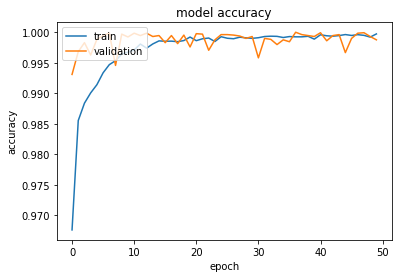

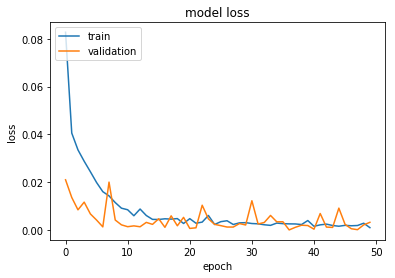

In [28]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [29]:
#import pickle
#pickle.dump(model, open('/home/intern_eyecare/Desktop/EEG/cnn_model.pkl','wb'))
model.save('/home/intern_eyecare/Desktop/EEG/new_cnn_model_smote.pkl')

In [30]:
## predict on test data - check metrics
#y_pred = model_svc.predict(X_test_scaled)

nrows2, ncols2 = X_test_scaled.shape
X_test_array =  X_test_scaled.reshape(nrows2, ncols2, 1)
y_pred = model.predict(X_test_array)

In [31]:
print(y_test.head(2))
print('')
print(y_test.tail(3))

   class2
0       0
1       0

      class2
9915       1
9916       1
9917       1


In [27]:
#y_test.dtypes()

TypeError: 'Series' object is not callable

In [32]:
y_pred

array([[3.6637021e-36],
       [0.0000000e+00],
       [0.0000000e+00],
       ...,
       [2.5213869e-14],
       [2.7816990e-11],
       [2.7498039e-12]], dtype=float32)

In [33]:
# convert array to dataframe

y_pred2 = pd.DataFrame(y_pred)
print(y_pred2.head(2))
print('')
print(y_pred2.tail(2))

              0
0  3.663702e-36
1  0.000000e+00

                 0
9916  2.781699e-11
9917  2.749804e-12


In [34]:
y_pred3 = round(y_pred2)
y_pred3
print(y_pred3.head(2))
print('')
print(y_pred3.tail(2))

     0
0  0.0
1  0.0

        0
9916  0.0
9917  0.0


In [35]:
y_pred3[0].unique()

array([0., 1.])

In [36]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
## Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

class_names = [0,1] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred3)
np.set_printoptions(precision=2)
print(cnf_matrix)  #(confusion_matrix(y_test, y_pred3))

[[7982   37]
 [ 450 1449]]


Normalized confusion matrix
[[1.   0.  ]
 [0.24 0.76]]


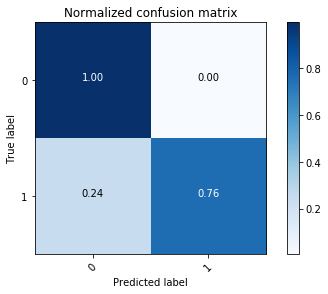

In [38]:
# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


In [39]:
## join the test set predictions & actual values into a dataframe
res = y_pred3
res.columns = ['pred']
res.head(2)

,pred
0,0.0
1,0.0


In [40]:
res = pd.concat([res,y_test], axis=1)
res.head(2)

,pred,class2
0,0.0,0
1,0.0,0


In [41]:
precision_recall_fscore_support(y_test,y_pred3)

# layout of results
# precision: class 0, class 1   ==> [0: wake; 1: sleep/drowsy/fatigue]
# recall: class 0, class 1
# f1 score: class 0, class 1
# support: class 0, class 1

## INFERENCE: recall is low for sleep state

(array([0.95, 0.98]),
 array([1.  , 0.76]),
 array([0.97, 0.86]),
 array([8019, 1899]))

In [42]:
#print(classification_report(y_test, y_pred3, target_names=class_names))
print(classification_report(res['class2'], res['pred'], target_names=class_names))

TypeError: object of type 'int' has no len()